# Forecasting Building Energy Consumption

In [1]:
# done in Google Colab

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
#import os
mpl.rcParams['figure.figsize'] = (16, 8)
mpl.rcParams['axes.grid'] = False

from fbprophet import Prophet
# interactive plot package
from fbprophet.plot import plot_plotly, plot_components_plotly
# forecast evaluation
from fbprophet.diagnostics import cross_validation, performance_metrics

In [3]:
# ensure data file is in colab directory before running this cell
df = pd.read_csv('forecast_data_v1.csv')

In [4]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [5]:
df

Datetime  ...  Outside Air Temp (C)
0    2020-06-01 01:00:00  ...                  14.6
1    2020-06-01 02:00:00  ...                  13.6
2    2020-06-01 03:00:00  ...                  13.6
3    2020-06-01 04:00:00  ...                  12.6
4    2020-06-01 05:00:00  ...                  12.6
...                  ...  ...                   ...
8754 2021-05-31 19:00:00  ...                  23.0
8755 2021-05-31 20:00:00  ...                  24.0
8756 2021-05-31 21:00:00  ...                  22.0
8757 2021-05-31 22:00:00  ...                  21.0
8758 2021-05-31 23:00:00  ...                  21.0

[8759 rows x 4 columns]

In [6]:
# check annual building energy consumption 
df['Hourly Energy Cons (kWh)'].sum()

216195.0

Building Energy Consumption Line Plot

In [7]:
fig = px.line(df, x='Datetime', y='Hourly Energy Cons (kWh)', hover_data=['Outside Air Temp (C)'], title='Building Energy Consumption')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=2, label="3m", step="month", stepmode="backward"),
            dict(count=3, label="6m", step="month", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

Feature Plots


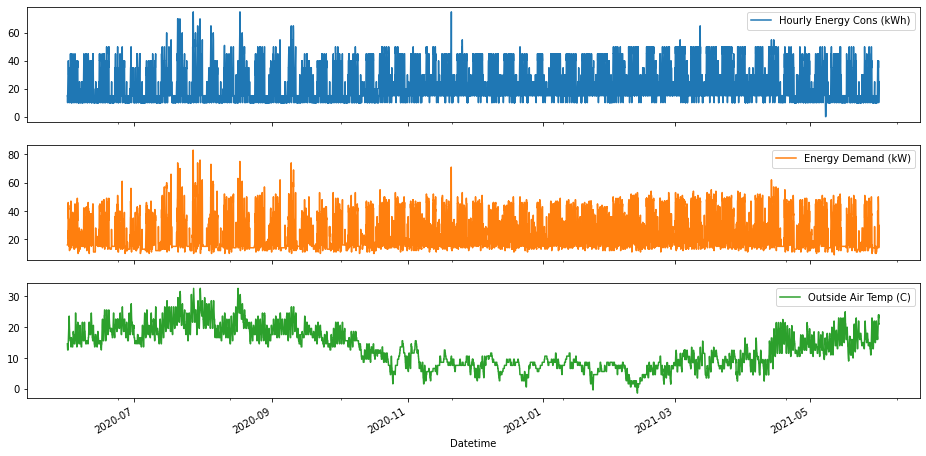

In [8]:
plot_df = df.set_index('Datetime')

plot_df.plot(figsize=(16,8),subplots=True);

## Univariate Forecast of Energy Consumption  
### Baseline Forecast Model

In [9]:
df_uni = df.reset_index()[['Datetime', 'Hourly Energy Cons (kWh)']].copy()
df_uni.columns = ['ds', 'y']

In [10]:
df_uni

ds     y
0    2020-06-01 01:00:00  15.0
1    2020-06-01 02:00:00  15.0
2    2020-06-01 03:00:00  10.0
3    2020-06-01 04:00:00  15.0
4    2020-06-01 05:00:00  15.0
...                  ...   ...
8754 2021-05-31 19:00:00  10.0
8755 2021-05-31 20:00:00  15.0
8756 2021-05-31 21:00:00  15.0
8757 2021-05-31 22:00:00  25.0
8758 2021-05-31 23:00:00  25.0

[8759 rows x 2 columns]

In [11]:
df_uni.isnull().sum()

ds    0
y     0
dtype: int64

In [12]:
# export dataframe for streamlit app
df_uni.to_csv('univariate_forecast.csv', index=False)

In [13]:
# try to predict on a 1 week time period: 168 hours
# train test split
test_uni = df_uni[(df_uni['ds'] >= '2021-05-25 00:00:00')]     # last week of data
train_uni = df_uni[(df_uni['ds'] < '2021-05-25 00:00:00')]

In [14]:
print(train_uni.shape)
print(test_uni.shape)

(8591, 2)
(168, 2)


In [15]:
train_uni.tail()

ds     y
8586 2021-05-24 19:00:00  15.0
8587 2021-05-24 20:00:00  10.0
8588 2021-05-24 21:00:00  15.0
8589 2021-05-24 22:00:00  10.0
8590 2021-05-24 23:00:00  15.0

In [16]:
test_uni

ds     y
8591 2021-05-25 00:00:00  15.0
8592 2021-05-25 01:00:00  15.0
8593 2021-05-25 02:00:00  10.0
8594 2021-05-25 03:00:00  15.0
8595 2021-05-25 04:00:00  15.0
...                  ...   ...
8754 2021-05-31 19:00:00  10.0
8755 2021-05-31 20:00:00  15.0
8756 2021-05-31 21:00:00  15.0
8757 2021-05-31 22:00:00  25.0
8758 2021-05-31 23:00:00  25.0

[168 rows x 2 columns]

In [17]:
# begin prophet forecasting
m = Prophet(interval_width=0.9) # 90% CI
m.fit(train_uni)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [18]:
future = m.make_future_dataframe(periods=len(test_uni), freq='H')
future

ds
0    2020-06-01 01:00:00
1    2020-06-01 02:00:00
2    2020-06-01 03:00:00
3    2020-06-01 04:00:00
4    2020-06-01 05:00:00
...                  ...
8753 2021-05-31 19:00:00
8754 2021-05-31 20:00:00
8755 2021-05-31 21:00:00
8756 2021-05-31 22:00:00
8757 2021-05-31 23:00:00

[8758 rows x 1 columns]

In [19]:
forecast = m.predict(future)

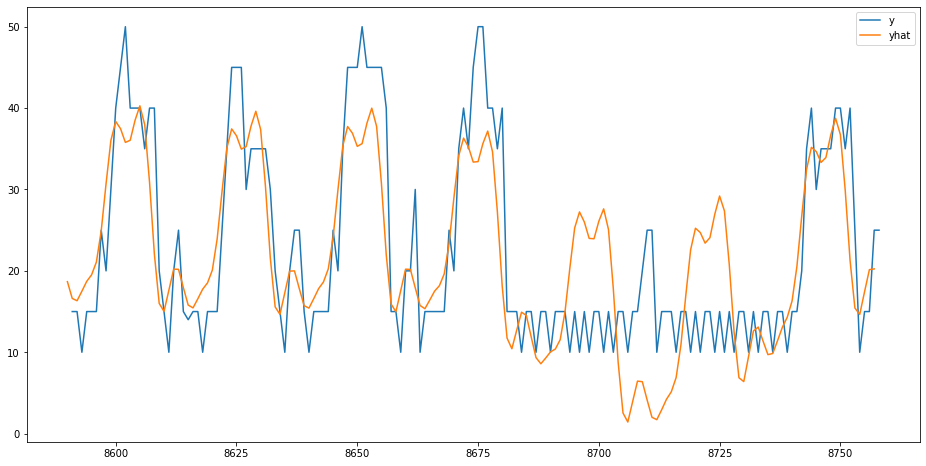

In [20]:
# visualize 1 week forecast 'yhat' compared to target 'y'
pd.concat([test_uni['y'], forecast['yhat'][-168:]], axis=1).plot(figsize=(16,8));

In [21]:
# interactive plot of entire forecast
plot_plotly(m, forecast)

In [22]:
# forecast components to identify trend and seasonality
plot_components_plotly(m, forecast)

In [23]:
# model evaluation with time series cross validation
# see documentation: https://facebook.github.io/prophet/docs/diagnostics.html
cv_results = cross_validation(m, initial='4380 hours', horizon='720 hours')
cv_results.head()

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-12-10 23:00:00 and 2021-04-24 23:00:00


ds       yhat  ...     y              cutoff
0 2020-12-11 00:00:00  23.983540  ...  15.0 2020-12-10 23:00:00
1 2020-12-11 01:00:00  21.987522  ...  15.0 2020-12-10 23:00:00
2 2020-12-11 02:00:00  21.761460  ...  15.0 2020-12-10 23:00:00
3 2020-12-11 03:00:00  22.819599  ...  15.0 2020-12-10 23:00:00
4 2020-12-11 04:00:00  23.572043  ...  20.0 2020-12-10 23:00:00

[5 rows x 6 columns]

In [24]:
df_uni_performance = performance_metrics(cv_results)
df_uni_performance     # use .iloc[90:100] to view 7 day forecast

INFO:fbprophet:Skipping MAPE because y close to 0


horizon        mse      rmse       mae     mdape  coverage
0    3 days 00:00:00  46.513360  6.820070  5.567075  0.187780  0.954103
1    3 days 01:00:00  46.717884  6.835048  5.581961  0.188320  0.954103
2    3 days 02:00:00  46.726642  6.835689  5.592133  0.188679  0.954103
3    3 days 03:00:00  46.453863  6.815707  5.570501  0.188329  0.954103
4    3 days 04:00:00  46.738203  6.836534  5.585979  0.189280  0.952712
..               ...        ...       ...       ...       ...       ...
644 29 days 20:00:00  66.964996  8.183214  6.735251  0.225094  0.890264
645 29 days 21:00:00  66.881740  8.178126  6.738379  0.225094  0.891516
646 29 days 22:00:00  67.171250  8.195807  6.755263  0.225094  0.890125
647 29 days 23:00:00  68.351171  8.267477  6.803713  0.225094  0.886231
648 30 days 00:00:00  68.487236  8.275702  6.809573  0.225102  0.884562

[649 rows x 6 columns]

Univariate MDAPE (Median Absolute Percent Error)
* 3 day forecast:  18.8%
* 1 week forecast: 21.2%
* 30 day forecast: 22.5%

## Multivariate Forecast of Energy Consumption  
### Better Forecast Model

In [25]:
df_multi = df.copy()
df_multi.columns = ['ds', 'y', 'demand', 'temp']
df_multi

ds     y  demand  temp
0    2020-06-01 01:00:00  15.0    16.0  14.6
1    2020-06-01 02:00:00  15.0    16.0  13.6
2    2020-06-01 03:00:00  10.0    16.0  13.6
3    2020-06-01 04:00:00  15.0    16.0  12.6
4    2020-06-01 05:00:00  15.0    16.0  12.6
...                  ...   ...     ...   ...
8754 2021-05-31 19:00:00  10.0    14.0  23.0
8755 2021-05-31 20:00:00  15.0    14.0  24.0
8756 2021-05-31 21:00:00  15.0    27.0  22.0
8757 2021-05-31 22:00:00  25.0    30.0  21.0
8758 2021-05-31 23:00:00  25.0    22.0  21.0

[8759 rows x 4 columns]

In [26]:
df_multi.describe()

y       demand         temp
count  8759.000000  8759.000000  8759.000000
mean     24.682612    25.405982    13.061080
std      12.692877    12.779742     6.247983
min       0.000000     9.000000    -1.400000
25%      15.000000    15.000000     7.600000
50%      20.000000    20.000000    12.500000
75%      35.000000    35.000000    17.600000
max      75.000000    83.000000    32.600000

In [27]:
# demand is highly correlated with consumption
# confirmed this data is available before consumption, to ensure no leakage
df_multi[['y','demand']].corr()

y    demand
y       1.000000  0.943974
demand  0.943974  1.000000

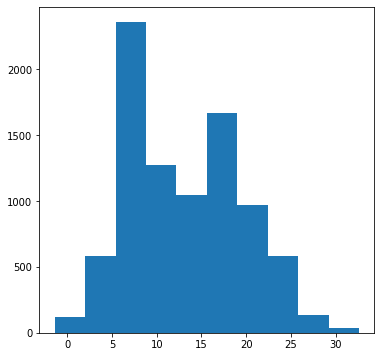

In [28]:
# plot temperature distribution
plt.figure(figsize=(6,6))
plt.hist(df_multi['temp']);

In [29]:
# temperature has almost no correlation with consumption
df_multi[['y','temp']].corr()

y     temp
y     1.00000 -0.05946
temp -0.05946  1.00000

In [30]:
# however, it improves if a temperature threshold is set
df_multi.query('temp > 18')[['y','temp']].corr()

y      temp
y     1.000000  0.227559
temp  0.227559  1.000000

In [31]:
df_multi.query('temp <= 18')[['y','temp']].corr()

y      temp
y     1.000000 -0.143997
temp -0.143997  1.000000

In [32]:
# create binary temperature threshold feature
def temp_thresh(temp):
  if temp > 18:
    return 1
  return 0

In [33]:
df_multi['temp thresh'] = df_multi['temp'].apply(temp_thresh)

In [34]:
# export dataframe for streamlitapp
df_multi.to_csv('multivariate_forecast.csv', index=False)

In [35]:
# extract month from datetime
df_multi['month'] = df_multi['ds'].dt.month

In [36]:
df_multi.isnull().sum()

ds             0
y              0
demand         0
temp           0
temp thresh    0
month          0
dtype: int64

In [37]:
# check temperature readings by month to confirm threshold
# we are essentially separating summer months from the rest of the year
df_multi[['temp', 'month']].groupby('month').agg({'temp':{'min', 'max', 'mean'}})

temp            
            mean   min   max
month                       
1       7.551613  -0.4  11.6
2       5.332738  -1.4  10.6
3       8.809421   2.5  15.5
4      12.683333   2.5  22.5
5      15.778226   9.0  25.0
6      18.373296  12.6  27.6
7      21.149731  13.6  32.6
8      20.574462  13.6  32.6
9      18.415278  12.6  26.6
10     12.171237   1.6  21.6
11      8.199168   1.6  15.6
12      7.129570   0.6  11.6

In [38]:
# train test split
test_multi = df_multi[(df_multi['ds'] >= '2021-05-25 00:00:00')]     # last week of data
train_multi = df_multi[(df_multi['ds'] < '2021-05-25 00:00:00')]

In [39]:
print(train_multi.shape)
print(test_multi.shape)

(8591, 6)
(168, 6)


In [40]:
test_multi.tail()

ds     y  demand  temp  temp thresh  month
8754 2021-05-31 19:00:00  10.0    14.0  23.0            1      5
8755 2021-05-31 20:00:00  15.0    14.0  24.0            1      5
8756 2021-05-31 21:00:00  15.0    27.0  22.0            1      5
8757 2021-05-31 22:00:00  25.0    30.0  21.0            1      5
8758 2021-05-31 23:00:00  25.0    22.0  21.0            1      5

In [41]:
m_multi = Prophet(interval_width=0.9)
m_multi.add_regressor('demand')
m_multi.add_regressor('temp thresh', standardize=False)

In [42]:
m_multi.fit(train_multi)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [43]:
future_multi = m_multi.make_future_dataframe(periods=len(test_multi), freq='H')
future_multi.tail()

ds
8753 2021-05-31 19:00:00
8754 2021-05-31 20:00:00
8755 2021-05-31 21:00:00
8756 2021-05-31 22:00:00
8757 2021-05-31 23:00:00

In [44]:
# add extra regressor data to future dataframe for prediction
future_multi['demand'] = df_multi['demand']
future_multi['temp thresh'] = df_multi['temp thresh']

In [45]:
future_multi

ds  demand  temp thresh
0    2020-06-01 01:00:00    16.0            0
1    2020-06-01 02:00:00    16.0            0
2    2020-06-01 03:00:00    16.0            0
3    2020-06-01 04:00:00    16.0            0
4    2020-06-01 05:00:00    16.0            0
...                  ...     ...          ...
8753 2021-05-31 19:00:00    14.0            1
8754 2021-05-31 20:00:00    14.0            1
8755 2021-05-31 21:00:00    14.0            1
8756 2021-05-31 22:00:00    27.0            1
8757 2021-05-31 23:00:00    30.0            1

[8758 rows x 3 columns]

In [46]:
forecast_multi = m_multi.predict(future_multi)

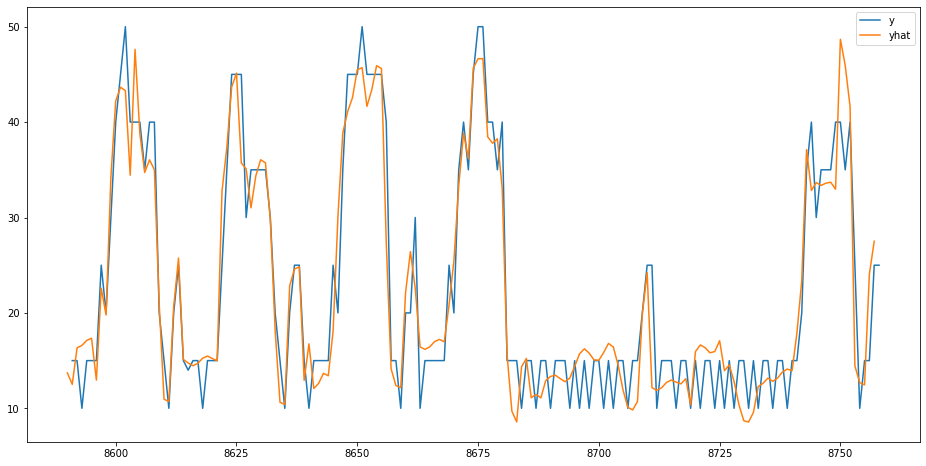

In [47]:
# visualize 1 week multivariate forecast 'yhat' compared to target 'y'
# this is an excellent fit
pd.concat([test_multi['y'], forecast_multi['yhat'][-168:]], axis=1).plot(figsize=(16,8));

In [48]:
# interactive plot of entire forecast
plot_plotly(m_multi, forecast_multi)

In [49]:
# multivariate forecast components
plot_components_plotly(m_multi, forecast_multi)

In [50]:
# model evaluation with time series cross validation
cv_results_multi = cross_validation(m_multi, initial='4380 hours', horizon='720 hours')
cv_results_multi.head()

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-12-10 23:00:00 and 2021-04-24 23:00:00


ds       yhat  ...     y              cutoff
0 2020-12-11 00:00:00  17.328754  ...  15.0 2020-12-10 23:00:00
1 2020-12-11 01:00:00  17.092394  ...  15.0 2020-12-10 23:00:00
2 2020-12-11 02:00:00  16.862254  ...  15.0 2020-12-10 23:00:00
3 2020-12-11 03:00:00  17.087880  ...  15.0 2020-12-10 23:00:00
4 2020-12-11 04:00:00  17.546440  ...  20.0 2020-12-10 23:00:00

[5 rows x 6 columns]

In [51]:
df_multi_performance = performance_metrics(cv_results_multi)
df_multi_performance        #.iloc[90:100] to view 7 day forecast

INFO:fbprophet:Skipping MAPE because y close to 0


horizon        mse      rmse       mae     mdape  coverage
0    3 days 00:00:00  15.794660  3.974250  2.998474  0.098477  0.895967
1    3 days 01:00:00  16.245603  4.030583  3.024357  0.098429  0.894298
2    3 days 02:00:00  16.366113  4.045505  3.034124  0.097986  0.893046
3    3 days 03:00:00  16.220417  4.027458  3.011890  0.096894  0.894298
4    3 days 04:00:00  16.143584  4.017908  3.003135  0.096661  0.895688
..               ...        ...       ...       ...       ...       ...
644 29 days 20:00:00  16.112940  4.014093  3.032008  0.099249  0.901252
645 29 days 21:00:00  16.085473  4.010670  3.031428  0.100460  0.900139
646 29 days 22:00:00  15.895000  3.986853  3.015077  0.100460  0.902643
647 29 days 23:00:00  16.067025  4.008369  3.033576  0.101183  0.899861
648 30 days 00:00:00  16.074854  4.009346  3.034325  0.100145  0.899861

[649 rows x 6 columns]

Multivariate MDAPE (Median Absolute Percent Error)
* 3 day forecast:  9.8%
* 1 week forecast: 8.3%
* 30 day forecast: 10.0%

It is interesting to see MDAPE decrease initially.
It reaches a minimum in the 5 to 6 day forecast window.

In [52]:
df_multi_performance[df_multi_performance.mdape <= 0.0785]

horizon        mse      rmse       mae     mdape  coverage
51 5 days 03:00:00  15.724679  3.965436  2.898436  0.078199  0.908206
52 5 days 04:00:00  15.830785  3.978792  2.911898  0.078471  0.908206
53 5 days 05:00:00  15.221874  3.901522  2.865608  0.078199  0.913769
54 5 days 06:00:00  15.479826  3.934441  2.887872  0.078471  0.912378
56 5 days 08:00:00  15.769112  3.971034  2.911393  0.077355  0.909597
57 5 days 09:00:00  15.654377  3.956561  2.901894  0.077278  0.910987
58 5 days 10:00:00  15.741852  3.967600  2.909467  0.077355  0.908206
59 5 days 11:00:00  16.002222  4.000278  2.916669  0.078199  0.908206
60 5 days 12:00:00  16.057698  4.007206  2.921000  0.078471  0.908206

Overall, the multivariate forecast can do a much better job as expected.